<a href="https://colab.research.google.com/github/pyon0615/Pocket-Physio/blob/main/Model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Video to images - more data for the data god
import cv2
vidcap = cv2.VideoCapture('big_buck_bunny_720p_5mb.mp4')
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

# 1. Set up and load data

In [2]:
import tensorflow as tf
import os
#os means operating system e.g. os.path.join('data') OR os.listdir('data')

**Avoid OOM errors by setting GPU Memory Consumption Growth:**
gpus = tf.config.experimental.list_physical_devices('GPU') --> THIS says what GPUs are on your device
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
--> THIS limits how much memory tensor flow can use

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
from google.colab import files
uploaded = files.upload()

import zipfile
import os

with zipfile.ZipFile("Training_data.zip", 'r') as zip_ref:
    zip_ref.extractall("exercise_data")  # Extracts into folder

Saving Training_data.zip to Training_data.zip


In [5]:
os.listdir('exercise_data/Training_data')

['push up', 'squat', 'russian twist']

In [6]:
import numpy as np
from matplotlib import pyplot as plt

dataset = tf.keras.utils.image_dataset_from_directory('exercise_data/Training_data')
#labels='inferred',label_mode='int', class_names=None, color_mode='rgb', batch_size=32, image_size=(256, 256),
#shuffle=True, seed=None, validation_split=None, ect

Found 1867 files belonging to 3 classes.


In [7]:
data_iterator = dataset.as_numpy_iterator()
batch = data_iterator.next() #Getting batch
batch[1]

array([2, 1, 0, 0, 0, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1,
       1, 0, 2, 0, 1, 1, 1, 2, 1, 0], dtype=int32)

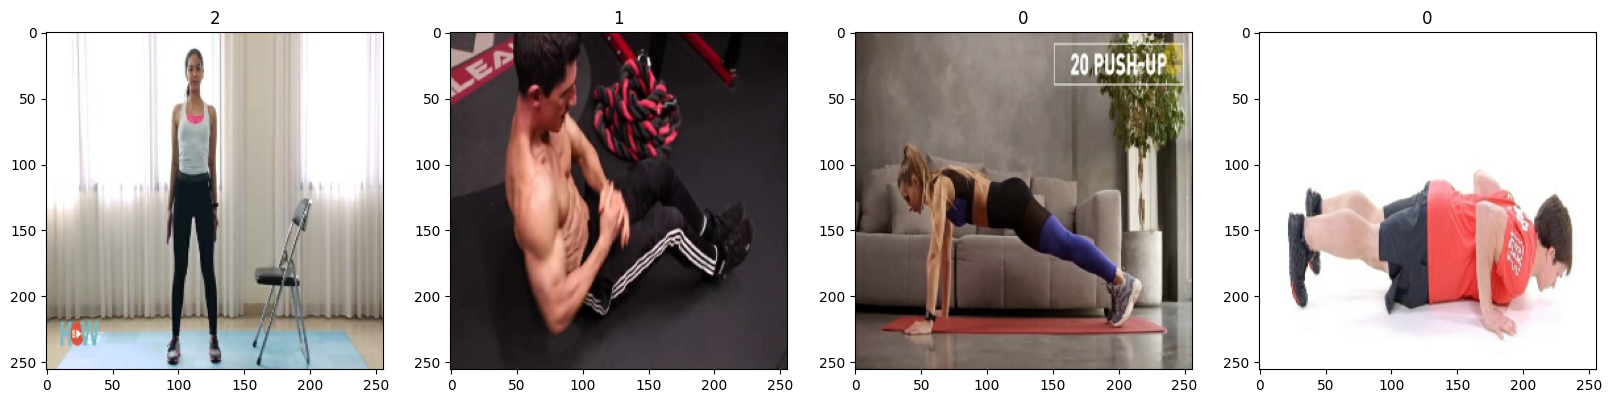

In [8]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
#Opening batch

# 2 - Preprocessing, data augmentation and splitting

In [9]:
#Rescale pixels from 0-1
dataset2 = dataset.map(lambda x,y: (x/255, y))
dataset2.as_numpy_iterator().next()

(array([[[[0.54893917, 0.57639015, 0.61560583],
          [0.5647059 , 0.5803922 , 0.62352943],
          [0.574169  , 0.58985525, 0.62514937],
          ...,
          [0.6022059 , 0.4492647 , 0.33553922],
          [0.5867647 , 0.43382353, 0.32009804],
          [0.5764706 , 0.43137255, 0.31764707]],
 
         [[0.5555224 , 0.58297336, 0.62218904],
          [0.5647059 , 0.5803922 , 0.62352943],
          [0.5771446 , 0.5928309 , 0.628125  ],
          ...,
          [0.6022059 , 0.4492647 , 0.33553922],
          [0.5819853 , 0.43382353, 0.32009804],
          [0.5764706 , 0.43137255, 0.32242647]],
 
         [[0.5580729 , 0.5855239 , 0.6247396 ],
          [0.5673407 , 0.58321077, 0.6261642 ],
          [0.5827091 , 0.59839535, 0.63368946],
          ...,
          [0.59900814, 0.45246246, 0.33873698],
          [0.58159465, 0.4365809 , 0.32293582],
          [0.5764706 , 0.4314951 , 0.32555148]],
 
         ...,
 
         [[0.10977712, 0.10943627, 0.1271446 ],
          [0.11519

In [10]:
# Define data augmentation layers (real-time)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

#Apply augmentation (training only)
dataset3 = dataset2.map(lambda x, y: (data_augmentation(x, training=True), y))

#Prefetch for performance
dataset3 = dataset3.prefetch(buffer_size=tf.data.AUTOTUNE)

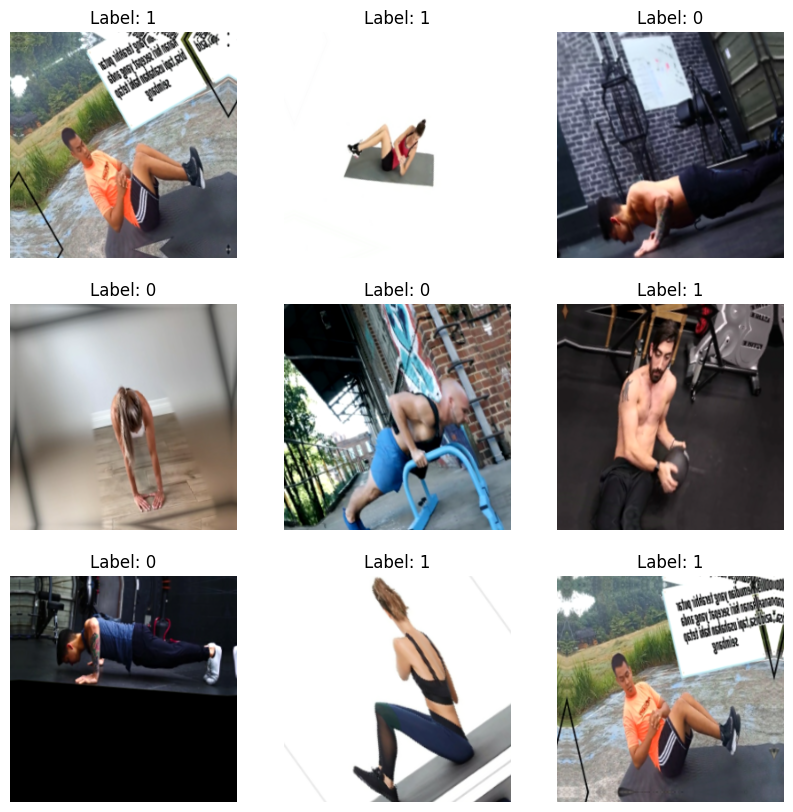

In [11]:
import matplotlib.pyplot as plt

for images, labels in dataset3.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    break

In [19]:
# CHAT:
# Count total batches
total_batches = tf.data.experimental.cardinality(dataset3).numpy()
val_batches = int(0.2 * total_batches)

# Split
val_ds = dataset3.take(val_batches)
train_ds = dataset3.skip(val_batches)

In [13]:
#Bald jesus
#len(dataset3)
#train_size = int(len(dataset3)*.7)
#val_size = int(len(dataset3)*.2)
#test_size = int(len(dataset3)*.1)
#train_size

41

In [15]:
#Bald jesus:
#train = dataset3.take(train_size)
#Val = dataset3.skip(train_size).take(val_size)
#test = dataset3.skip(train_size+val_size).take(test_size)

# Model Building


In [23]:
from tensorflow.keras import layers, models

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 3)),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 classes
])

In [24]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 52s 766ms/step - accuracy: 0.4394 - loss: 1.4489 - val_accuracy: 0.6080 - val_loss: 0.8346
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 675ms/step - accuracy: 0.7535 - loss: 0.5382 - val_accuracy: 0.9119 - val_loss: 0.2252
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 733ms/step - accuracy: 0.9103 - loss: 0.2711 - val_accuracy: 0.9574 - val_loss: 0.1675
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 649ms/step - accuracy: 0.9499 - loss: 0.1537 - val_accuracy: 0.9688 - val_loss: 0.0943
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 737ms/step - accuracy: 0.9619 - loss: 0.1276 - val_accuracy: 0.9773 - val_loss: 0.0786
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 656ms/step - accuracy: 0.9676 - loss: 0.1048 - val_accuracy: 0.9489 - val_loss: 0.1602
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 737ms/step - accuracy: 0.9673 - loss: 0.1187 - val_accuracy: 0.9545 - val_loss: 0.1122
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 42s 743ms/step - accuracy: 0.9770 - loss: 0.0928 - val_accu

In [1]:
import matplotlib.pyplot as plt

# Accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

# Loss over epochs
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

NameError: name 'history' is not defined

In [ ]:
import scikit-learn as skl

